In [66]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import scipy.sparse as sp
import seaborn as sns
from lime.lime_text import LimeTextExplainer



In [67]:
df = pd.read_csv('fake_news.csv')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


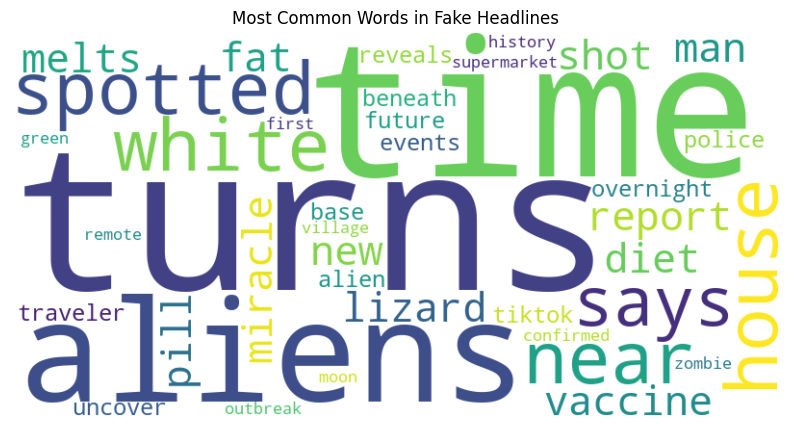

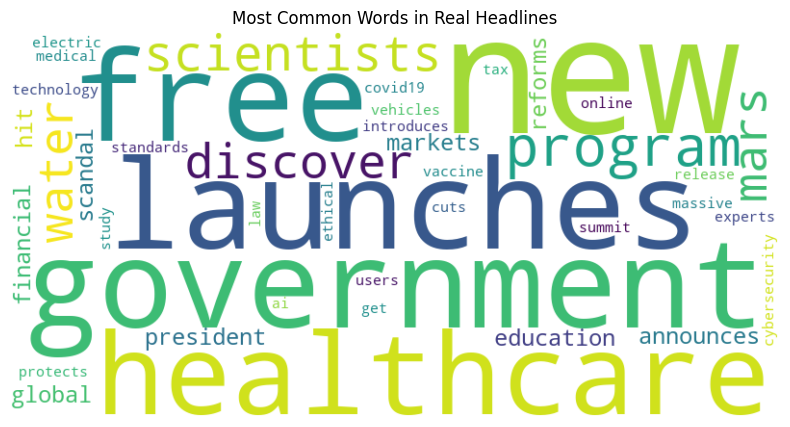

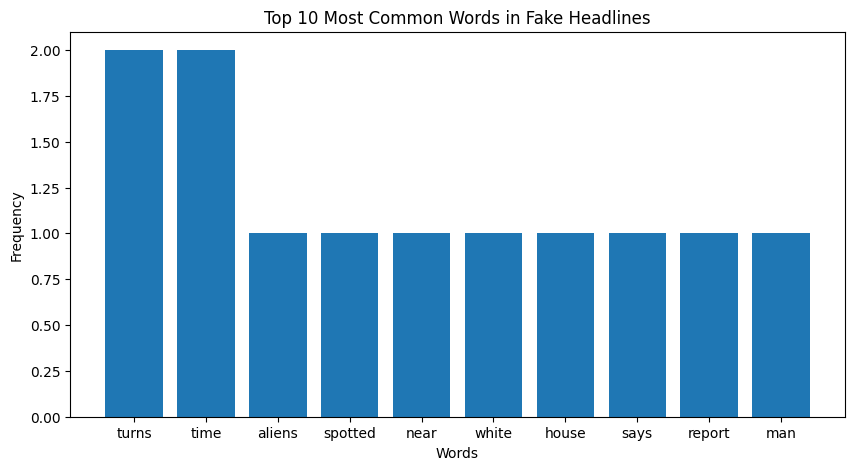

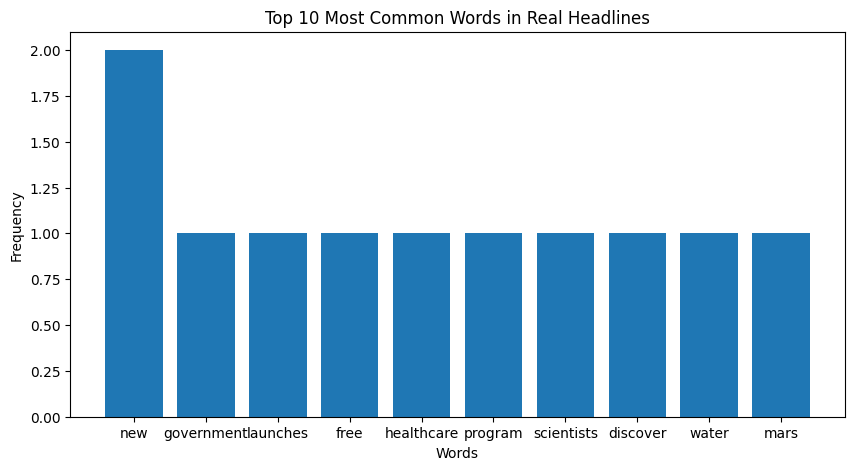

In [68]:
########################################## 1. EDA Expasion ########################################
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

fake_headlines = df[df['label'] == 'Fake']['headline']
real_headlines = df[df['label'] == 'Real']['headline']

# Function to process and count words
def process_EDAtext(headlines):
    words = []
    for headline in headlines:
        headline = headline.translate(str.maketrans('', '', string.punctuation)).lower()
        headline_words = headline.split()
        headline_words = [word for word in headline_words if word not in stop_words]
        words.extend(headline_words)
    return Counter(words)

fake_word_counts = process_EDAtext(fake_headlines)
real_word_counts = process_EDAtext(real_headlines)

# Generate word clouds
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(fake_word_counts, 'Most Common Words in Fake Headlines')
generate_word_cloud(real_word_counts, 'Most Common Words in Real Headlines')

# Generate bar plots
def generate_bar_plot(word_counts, title, top_n=10):
    most_common = word_counts.most_common(top_n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

generate_bar_plot(fake_word_counts, 'Top 10 Most Common Words in Fake Headlines')
generate_bar_plot(real_word_counts, 'Top 10 Most Common Words in Real Headlines')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\linde\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


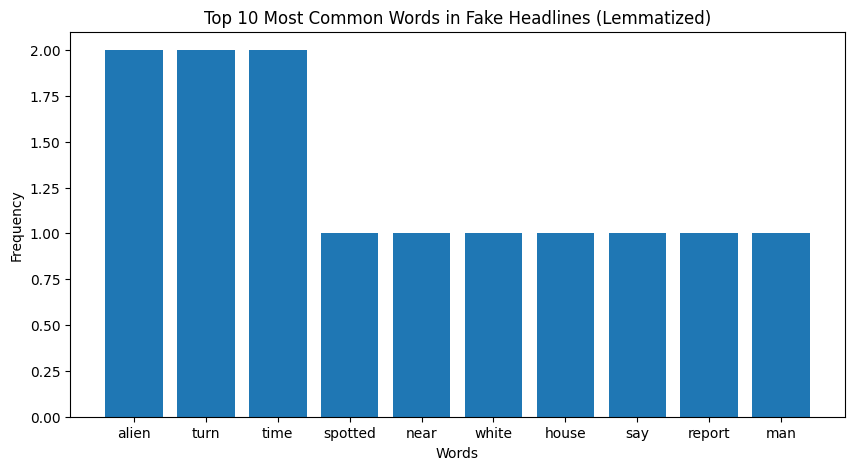

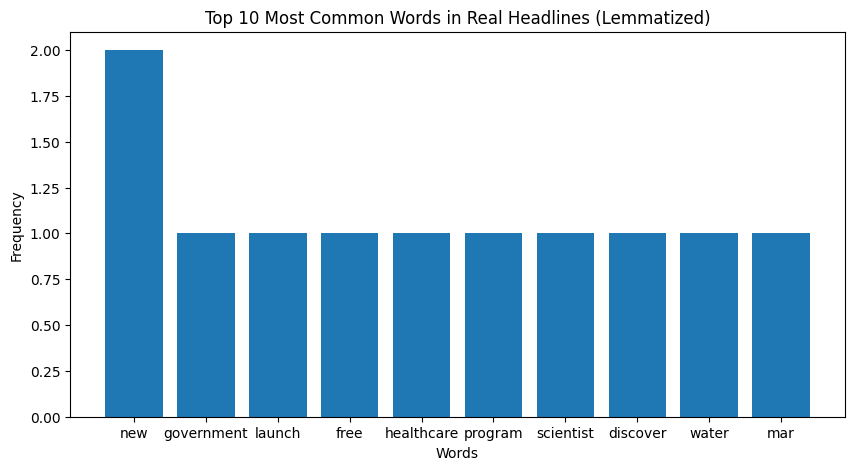

In [69]:
######################  2 Advanced Text Preprocessing ########################################
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Function to process and count words with lemmatization
def process_PreprocessingText(headlines):
    words = []
    for headline in headlines:
        headline = headline.translate(str.maketrans('', '', string.punctuation)).lower()
        headline_words = headline.split()
        headline_words = [lemmatizer.lemmatize(word) for word in headline_words if word not in stop_words]
        words.extend(headline_words)
    return Counter(words)

fake_word_counts = process_PreprocessingText(fake_headlines)
real_word_counts = process_PreprocessingText(real_headlines)

# Generate bar plots
def generate_bar_plot(word_counts, title, top_n=10):
    most_common = word_counts.most_common(top_n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

generate_bar_plot(fake_word_counts, 'Top 10 Most Common Words in Fake Headlines (Lemmatized)')
generate_bar_plot(real_word_counts, 'Top 10 Most Common Words in Real Headlines (Lemmatized)')

In [70]:
######################  3 Class Imbalance Handling ####################################

# 3. Class Imbalance Handling
real_headlines_undersampled = real_headlines.sample(len(fake_headlines), random_state=42)
balanced_df = pd.concat([fake_headlines, real_headlines_undersampled]).reset_index(drop=True)
print(f"Number of Fake headlines: {len(fake_headlines)}")
print(f"Number of Real headlines after undersampling: {len(real_headlines_undersampled)}")
 
# Converting the balanced_df Series to a DataFrame with labels
balanced_df = pd.DataFrame({'headline': balanced_df, 'label': ['Fake'] * len(fake_headlines) + ['Real'] * len(real_headlines_undersampled)})
 
# Vectorizing text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanced_df['headline'])
y = balanced_df['label']
 
# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Original dataset size: {X.shape[0]}")
print(f"Resampled dataset size: {X_resampled.shape[0]}")

Number of Fake headlines: 7
Number of Real headlines after undersampling: 7
Original dataset size: 14
Resampled dataset size: 14


In [ ]:
######################  4 Hyperparameter Tuning ####################################
from sklearn.model_selection import GridSearchCV

# Function to preprocess text with lemmatization
def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to headlines
df['headline'] = df['headline'].apply(preprocess_text)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['label'], test_size=0.3, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_vec, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_vec)

# Evaluate the model
print("Best Random Forest Model Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
######################  5 Cross-Validation Evaluation ####################################

df['headline'] = df['headline'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']


rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=True, random_state=42
)

svm_model = SVC(C=10, kernel='rbf', gamma='scale', random_state=42)

# Perform K-Fold cross-validation (K=5)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')

# Report the average accuracy and standard deviation
print("Random Forest Cross-Validation Results:")
print(f"Average Accuracy: {rf_scores.mean():.4f}")
print(f"Standard Deviation: {rf_scores.std():.4f}")

print("\nSVM Cross-Validation Results:")
print(f"Average Accuracy: {svm_scores.mean():.4f}")
print(f"Standard Deviation: {svm_scores.std():.4f}")

Random Forest Cross-Validation Results:
Average Accuracy: 0.4000
Standard Deviation: 0.2494

SVM Cross-Validation Results:
Average Accuracy: 0.5333
Standard Deviation: 0.2667


In [ ]:
######################  6 Feature Engineering ####################################

df['headline'] = df['headline'].apply(preprocess_text)

# Create custom features
def create_custom_features(headlines):
    features = []
    for headline in headlines:
        length = len(headline)
        capitals = sum(1 for char in headline if char.isupper())
        punctuation = sum(1 for char in headline if char in string.punctuation)
        features.append([length, capitals, punctuation])
    return features

# Extract custom features
custom_features = create_custom_features(df['headline'])

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['headline'])

# Combine TF-IDF features with custom features
X_combined = sp.hstack((X_tfidf, custom_features))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Performance with Custom Features:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Model Performance with Custom Features:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4


c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Random Forest Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


SVM Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


Logistic Regression Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg 

c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

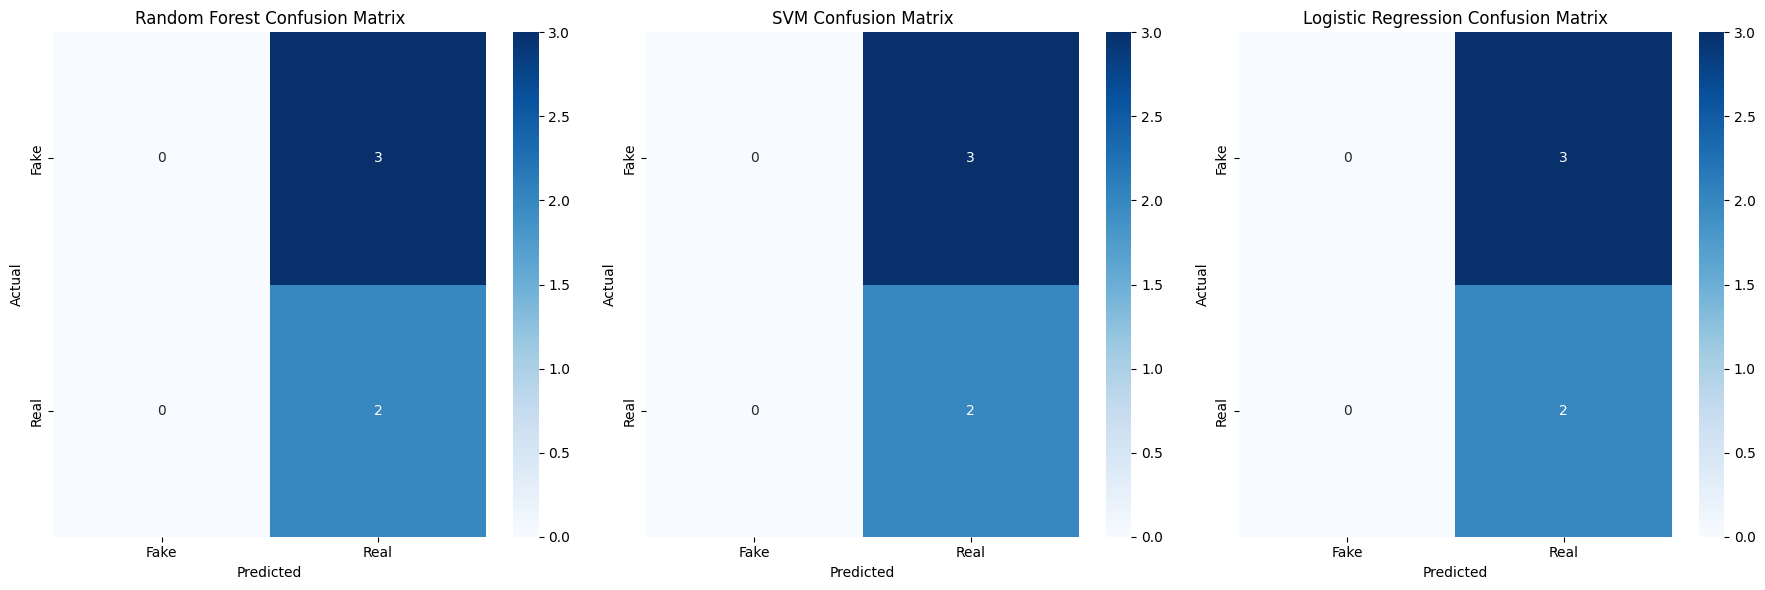

In [ ]:
######################  7 Confusion Matrix Analysis ####################################

# Apply preprocessing to headlines
df['headline'] = df['headline'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

# Train models and generate confusion matrices
conf_matrices = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n")

# Plot confusion matrices side-by-side
plt.figure(figsize=(18, 6))
for i, (name, conf_matrix) in enumerate(conf_matrices.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
######################  8 Explainable AI (XAI) ####################################

# Apply preprocessing to headlines
df['headline'] = df['headline'].apply(preprocess_text)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['label'], test_size=0.3, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the best-performing model (SVM in this case)
svm_model = SVC(random_state=42, probability=True)  
svm_model.fit(X_train_vec, y_train)

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['Fake', 'Real'])

# Function to predict probabilities using the model
def predict_proba(texts):
    return svm_model.predict_proba(vectorizer.transform(texts))

# Explain a few predictions
for i in range(3):  
    text_instance = X_test.iloc[i] 
    true_label = y_test.iloc[i]
    print(f"Headline: {text_instance}")
    print(f"True Label: {true_label}")
    
    # Explain the prediction
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    print("Explanation:")
    print(exp.as_list())  # Print the explanation in text format
    print("\n")

Headline: police uncover alien base beneath supermarket
True Label: Fake
Explanation:
[(np.str_('alien'), 0.13517747222314547), (np.str_('base'), -1.6883116775305765e-05), (np.str_('supermarket'), -1.4502154011881818e-05), (np.str_('beneath'), -1.3364676848871553e-05), (np.str_('police'), -1.0301865843460804e-05), (np.str_('uncover'), -1.62302166469018e-06)]


Headline: moon turn green first time history
True Label: Fake
Explanation:
[(np.str_('turn'), 0.08752298910533902), (np.str_('time'), 0.05854668645415646), (np.str_('first'), 0.004226623202653331), (np.str_('history'), 0.003893216103746516), (np.str_('moon'), 0.003582074655972738), (np.str_('green'), 0.0035328063051940552)]


Headline: government launch free healthcare program
True Label: Real
Explanation:
[(np.str_('government'), 0.0), (np.str_('launch'), 0.0), (np.str_('free'), 0.0), (np.str_('healthcare'), 0.0), (np.str_('program'), 0.0)]




In [ ]:
######################  9 Ensemble Modeling ####################################

df['headline'] = df['headline'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define individual models
log_reg = LogisticRegression(random_state=42)
svm = SVC(random_state=42, probability=True)  # Enable probability for VotingClassifier
rf = RandomForestClassifier(random_state=42)

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('svm', svm),
        ('rf', rf)
    ],
    voting='soft'  
)

# Train and evaluate individual models
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "Random Forest": rf,
    "VotingClassifier": voting_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n")

Logistic Regression Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


SVM Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


Random Forest Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg 

c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
######################  9 Ensemble Modeling ####################################

df['headline'] = df['headline'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']

# Train the best-performing model (SVM in this case)
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X, y)

# Collect real-world headlines
real_headlines = [
    "NASA announces new mission to explore Jupiter's moons",  # Real
    "Global leaders meet to discuss climate change solutions",  # Real
    "New study shows benefits of regular exercise on mental health",  # Real
    "Tech companies pledge to reduce carbon emissions by 2030",  # Real
    "Economists predict steady growth in global markets next year"  # Real
]

fake_headlines = [
    "Local man discovers he's actually a loaf of bread",  # Fake (The Onion)
    "Government announces new tax on breathing air",  # Fake (The Onion)
    "Scientists confirm that the moon is made of cheese",  # Fake (The Onion)
    "New law requires all pets to wear tiny shoes",  # Fake (The Onion)
    "Aliens demand to speak to Earth's manager"  # Fake (The Onion)
]

# Combine real and fake headlines
test_headlines = real_headlines + fake_headlines
true_labels = ['Real'] * 5 + ['Fake'] * 5

test_headlines_processed = [preprocess_text(headline) for headline in test_headlines]
X_test = vectorizer.transform(test_headlines_processed)

# Predict using the best model
predictions = svm_model.predict(X_test)

# Display results
for headline, true_label, pred_label in zip(test_headlines, true_labels, predictions):
    print(f"Headline: {headline}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print("\n")

Headline: NASA announces new mission to explore Jupiter's moons
True Label: Real
Predicted Label: Real


Headline: Global leaders meet to discuss climate change solutions
True Label: Real
Predicted Label: Real


Headline: New study shows benefits of regular exercise on mental health
True Label: Real
Predicted Label: Real


Headline: Tech companies pledge to reduce carbon emissions by 2030
True Label: Real
Predicted Label: Real


Headline: Economists predict steady growth in global markets next year
True Label: Real
Predicted Label: Real


Headline: Local man discovers he's actually a loaf of bread
True Label: Fake
Predicted Label: Real


Headline: Government announces new tax on breathing air
True Label: Fake
Predicted Label: Real


Headline: Scientists confirm that the moon is made of cheese
True Label: Fake
Predicted Label: Real


Headline: New law requires all pets to wear tiny shoes
True Label: Fake
Predicted Label: Real


Headline: Aliens demand to speak to Earth's manager
True La